# Time Series Analysis of Hipparcos

This time series analysis of Hipparcos data was an attempt at measuring the rotation period of the M-type star GJ 3942.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from astropy.timeseries import LombScargle
import lightkurve as lk

## Rotation Period
Our rotation period used is that of a best-fit frequency, while the recorded rotation period is 16.3 days in <a href="https://ui.adsabs.harvard.edu/abs/2017A%26A...608A..63P/abstract">Perger et al. (2021)</a>. Within the TESS time series analysis, a best-fit frequency of 15.7 was found and used. The fonts and sizes for plots are also stated here.

In [2]:
# Input Signal (Best-Fit)
rp = 15.7

# Fonts and Sizes
figsize = (9, 5)
title_font = 18
label_font = 14
tick_font = 12

## Hipparcos Dataset

We define a variable to contain the data from Hipparcos. The file path would need to be adjusted based on where you have the file.

In [3]:
data = "/Users/andrewandmatthewfonseca/NWelch/GJ3942/GJ3942_Hipparcos_Photometric_Light_Curve.tbl.txt"
table = pd.read_table(data, comment='#', delim_whitespace=True)
colnames = ['BJD', 'Magnitude']
print(table)

              BJD  Magnitude  Magnitude_Uncertainty  Data_Quality_Flag  \
0    2.447895e+06    10.2286                  0.022                  1   
1    2.447895e+06    10.2396                  0.023                  1   
2    2.447947e+06    10.2634                  0.024                  1   
3    2.447947e+06    10.2482                  0.022                  1   
4    2.447947e+06    10.2523                  0.025                  0   
..            ...        ...                    ...                ...   
111  2.448950e+06    10.2535                  0.026                  0   
112  2.448950e+06    10.2699                  0.033                  0   
113  2.449055e+06    10.2837                  0.033                  2   
114  2.449055e+06    10.2951                  0.021                  0   
115  2.449055e+06    10.2724                  0.030                  0   

     Accepted  
0           1  
1           1  
2           1  
3           1  
4           1  
..        ...  

## Scatter Plot and Sigma Clipping

With this scatter plot, we can see the distribution of the sigma clipped data points by 3$\sigma$. We also catch the unclipped Hipparcos data to use for later down the notebook.

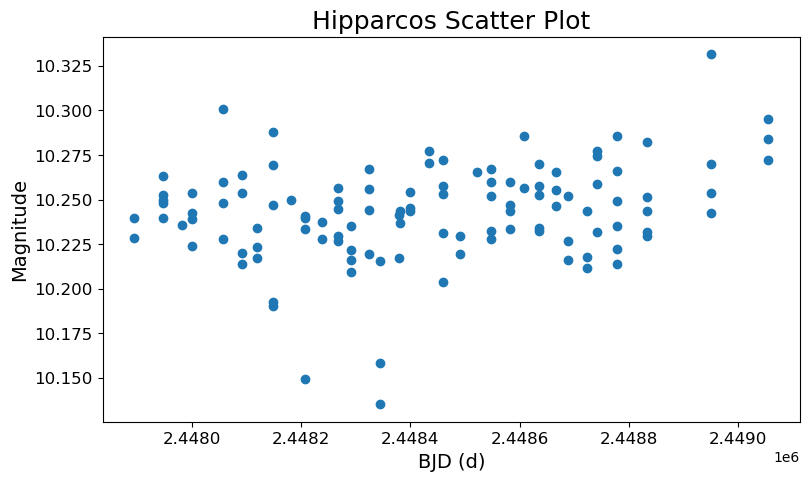

In [4]:
# Loading Hipparcos data
bjd, mag = np.loadtxt(data, skiprows=124, unpack=True, usecols=[0, 1])
std_dev = np.std(mag)

# Sigma Clipping
good_data = np.where(np.abs(mag - np.mean(mag)) < 3 * std_dev)[0]
bjd = bjd[good_data]
mag = mag[good_data]

# Plotting
plt.figure(figsize=figsize)
plt.scatter(bjd, mag)
plt.title('Hipparcos Scatter Plot', fontsize=title_font)
plt.xlabel('BJD (d)', fontsize=label_font)
plt.ylabel('Magnitude', fontsize=label_font)
plt.tick_params(axis='both', which='major', labelsize=tick_font)
plt.show()

# Unclipped Hipparcos Data
bjd_full, mag_full = np.loadtxt(data, skiprows=124, unpack=True, usecols=[0, 1])

## Histrogram

We take the sigma clipped data and create a histogram of the time steps. These time steps are in log base 10.

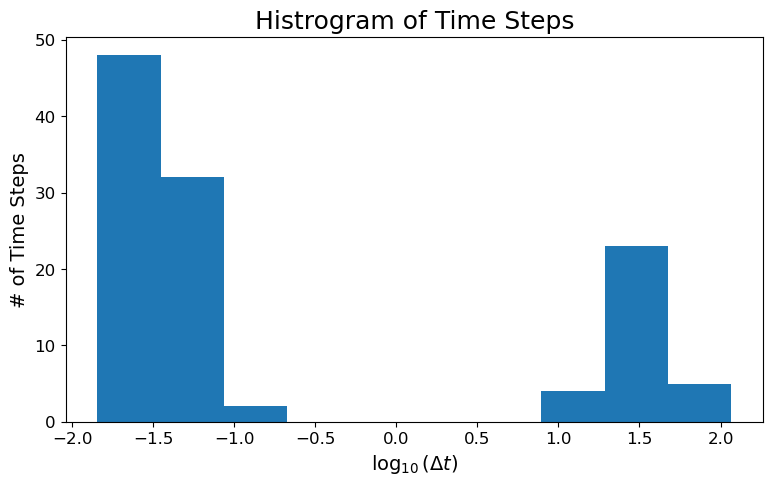

In [5]:
# Delta t 
dt = np.diff(bjd)

# Plotting
plt.figure(figsize=figsize)
plt.hist(np.log10(dt))
plt.title('Histrogram of Time Steps', fontsize=title_font)
plt.xlabel(r"$\log_{10}(\Delta t)$", fontsize=label_font)
plt.ylabel('# of Time Steps', fontsize=label_font)
plt.tick_params(axis='both', which='major', labelsize=tick_font)
plt.show()

## Periodogram (Lower Frequencies)

We create a periodogram from the LombScargle function using the data from Hipparcos. This periodogram shows the lower frequencies. Two vertical lines are created for the signal of the rotation period and the signal divied in half.

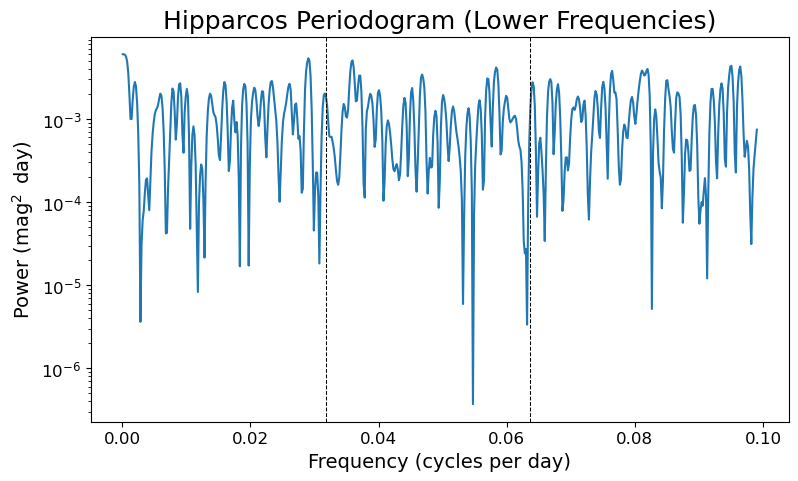

In [6]:
# Periodogram (Lower Frequencies)
freq, power = LombScargle(bjd, mag, normalization = 'psd').autopower(nyquist_factor=2)

# Plotting
plt.figure(figsize=figsize)
plt.semilogy(freq, power)
plt.title('Hipparcos Periodogram (Lower Frequencies)', fontsize=title_font)
plt.xlabel(r"Frequency (cycles per day)", fontsize=label_font)
plt.ylabel(r"Power ($\operatorname{mag}^2$ day)", fontsize=label_font)
plt.tick_params(axis='both', which='major', labelsize=tick_font)
plt.axvline(1/rp, linestyle='--', linewidth=0.75, color='black')
plt.axvline((1/rp)/2, linestyle='--', linewidth=0.75, color='black')
plt.show()

## Periodogram (Higher Frequencies)

This is a periodogram of the clipped Hipparcos data. This has higher frequencies compared to the periodogram above that shows lower frequencies.

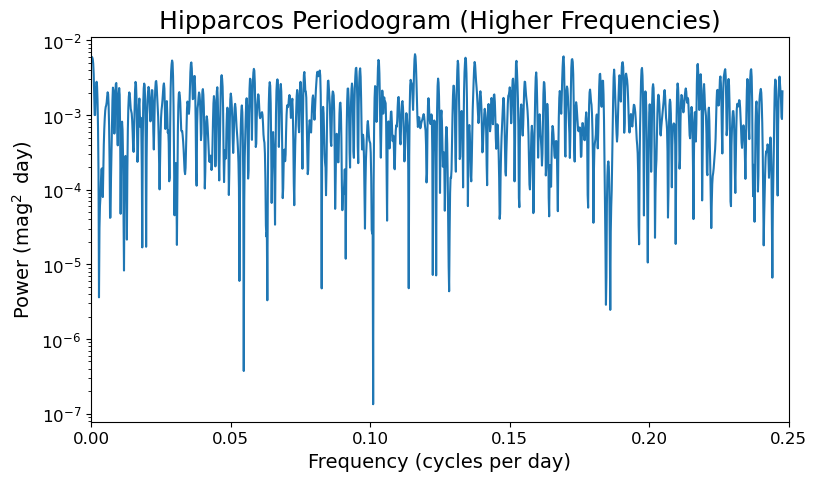

In [7]:
# Periodogram (Higher Frequencies)
cut_frequency, cut_power = LombScargle(bjd - bjd[0], mag, normalization="psd").autopower()

# Plotting
plt.figure(figsize=figsize)
plt.semilogy(cut_frequency, cut_power)
plt.title('Hipparcos Periodogram (Higher Frequencies)', fontsize=title_font)
plt.xlabel(r"Frequency (cycles per day)", fontsize=label_font)
plt.ylabel(r"Power ($\operatorname{mag}^2$ day)", fontsize=label_font)
plt.tick_params(axis='both', which='major', labelsize=tick_font)
plt.xlim(0, 0.25)
plt.show()

## Spectral Window (Full Data)

A new spectral window is created below using the full data found in the Hipparcos dataset, using a nyquist factor of 2.

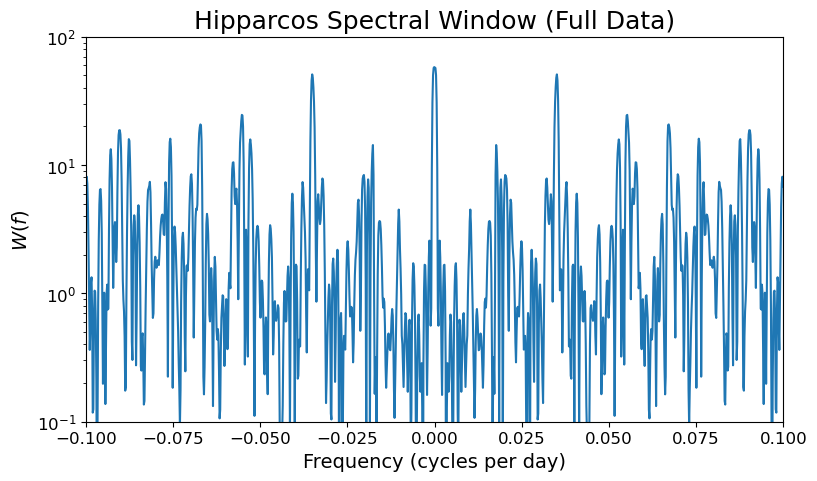

In [8]:
# Spectral Window (Full Data) 
freq, specwin = LombScargle(bjd_full - bjd_full[0], np.ones(len(bjd_full)), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)

# Plotting
plt.figure(figsize=figsize)
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
plt.title('Hipparcos Spectral Window (Full Data)', fontsize=title_font)
plt.xlabel(r"Frequency (cycles per day)", fontsize=label_font)
plt.ylabel(r"$W(f)$", fontsize=label_font)
plt.tick_params(axis='both', which='major', labelsize=tick_font)
plt.xlim(-0.1, 0.1)
plt.ylim(1e-1, 100)
plt.show()

## Spectral Window (Clipped Data)

Another spectral window is created, this time using the sigma-clipped data from the Hipparcos dataset. This also uses a nyquist factor of 2.

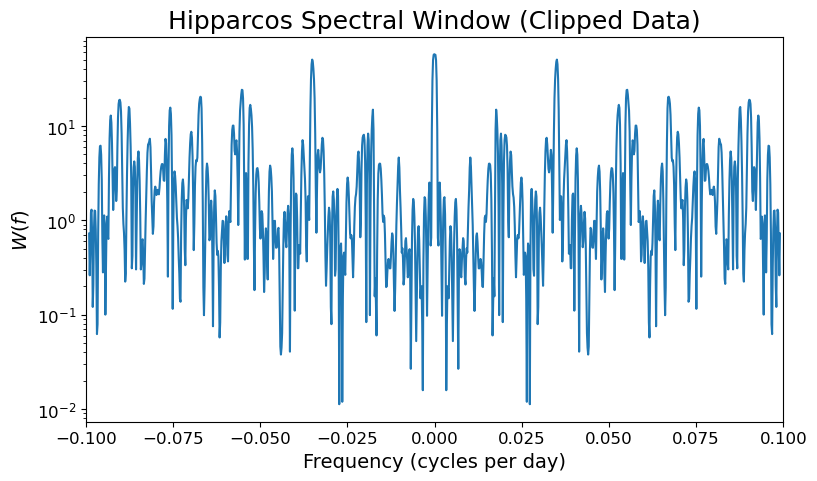

In [9]:
# Spectral Window (Clipped Data)
freq, specwin = LombScargle(bjd - bjd[0], np.ones(len(bjd)), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)

# Plotting
plt.figure(figsize=figsize)
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
plt.title('Hipparcos Spectral Window (Clipped Data)', fontsize=title_font)
plt.xlabel(r"Frequency (cycles per day)", fontsize=label_font)
plt.ylabel(r"$W(f)$", fontsize=label_font)
plt.tick_params(axis='both', which='major', labelsize=tick_font)
plt.xlim(-0.1, 0.1)
plt.show()

## Pseudo-Window (Full Data)

We create a pseudo-window from the full data of the Hipparcos dataset, using a nyquist factor of 2. 

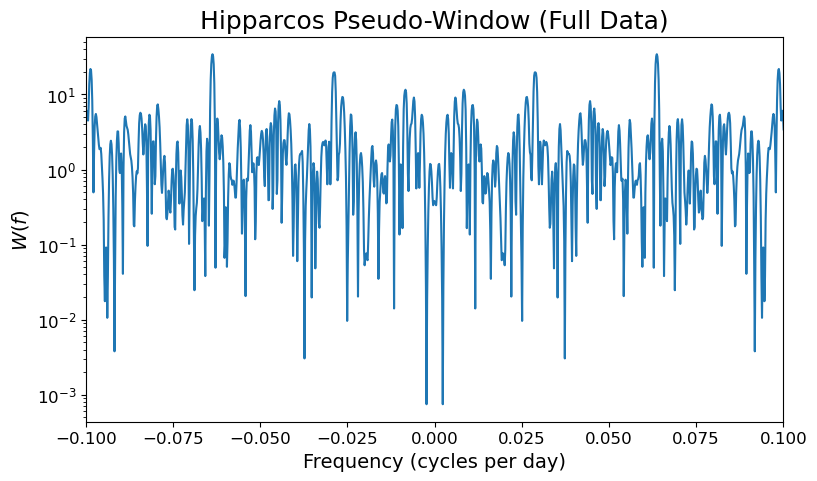

In [10]:
# Pseudo-Window (Full Data)
freq, specwin = LombScargle(bjd_full - bjd_full[0], np.sin(2*np.pi*(bjd_full-bjd_full[0])/rp), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)

# Plotting
plt.figure(figsize=figsize)
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
plt.title('Hipparcos Pseudo-Window (Full Data)', fontsize=title_font)
plt.xlabel(r"Frequency (cycles per day)", fontsize=label_font)
plt.ylabel(r"$W(f)$", fontsize=label_font)
plt.tick_params(axis='both', which='major', labelsize=tick_font)
plt.xlim(-0.1, 0.1)
plt.show()

## Pseudo-Window (Clipped Data)

The first plot below shows the pseudo-window using the clipped data of the Hipparcos dataset with a nyquist factor of 2. A vertical line is created at the positive and negative sides for the signal of the rotation period. The second plot below is the same pseudo-window using the clipped data of only the positive side.

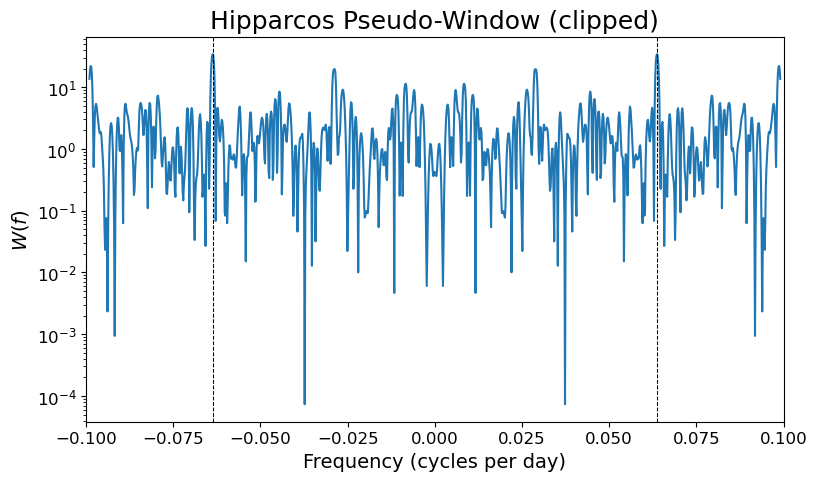

In [11]:
# Pseudo-Window (Clipped Data)
freq, specwin = LombScargle(bjd - bjd[0], np.sin(2*np.pi*(bjd-bjd[0])/rp), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)

# Plotting
plt.figure(figsize=(9, 5))
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
plt.title("Hipparcos Pseudo-Window (clipped)", fontsize=title_font)
plt.xlabel(r"Frequency (cycles per day)", fontsize=label_font)
plt.ylabel(r"$W(f)$", fontsize=label_font)
plt.tick_params(axis='both', which='major', labelsize=tick_font)
plt.xlim(-0.1, 0.1)
plt.axvline(1/rp, linestyle='--', linewidth=0.75, color='black')
plt.axvline(-(1/rp), linestyle='--', linewidth=0.75, color='black')
plt.show()

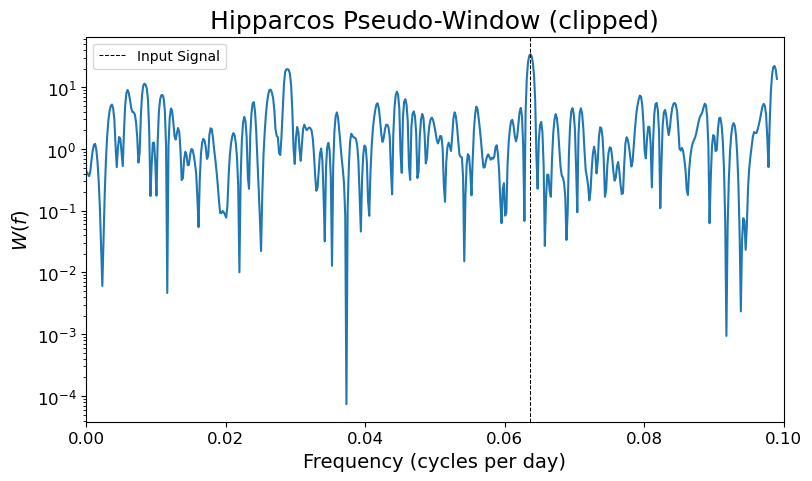

In [12]:
# Pseudo-Window (Clipped Data) (Positive Frequencies Only)
freq, specwin = LombScargle(bjd - bjd[0], np.sin(2*np.pi*(bjd-bjd[0])/rp), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)

# Selecting only positive frequencies
positive_freq = freq[freq > 0]
positive_specwin = specwin[freq > 0]

# Plotting
plt.figure(figsize=figsize)
plt.semilogy(positive_freq, positive_specwin)
plt.title("Hipparcos Pseudo-Window (clipped)", fontsize=title_font)
plt.xlabel(r"Frequency (cycles per day)", fontsize=label_font)
plt.ylabel(r"$W(f)$", fontsize=label_font)
plt.tick_params(axis='both', which='major', labelsize=tick_font)
plt.xlim(0, 0.1)
plt.axvline(1/rp, linestyle='--', linewidth=0.75, color='black', label='Input Signal')
plt.legend()
plt.show()

## Sources

Data Table:

 - https://exoplanetarchive.ipac.caltech.edu/overview/GJ%203942

Filter:
 - http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=Hipparcos/Hipparcos.Hp&&mode=browse&gname=Hipparcos&gname2=Hipparcos#filter